# Equações do Sistema

$G(s) = \dfrac{1}{\tau \cdot C_2R_1} \cdot \dfrac{1}{s^2+s\dfrac{\tau + C_1R_1}{\tau\cdot C_2R_1}+\dfrac{1}{\tau \cdot C_2R_1}}$, $\tau = C_1\cdot R_2$

$ω = \sqrt{\dfrac{1}{\tau \cdot C_2R_1}}$

$ζ = \dfrac{\tau+C_1R_1}{2\tau \cdot C_2\cdot R_1 \cdot \sqrt{\dfrac{1}{\tau \cdot C_2R_1}}} \ 
   = \dfrac{\tau+C_1R_1}{2\tau \cdot C_2\cdot R_1 \cdot ω}$

In [2]:
# Módulos
import numpy as np
import control as ct
import controle as ctl
# Cálculo de Parâmetros
NT = 18             # Emanuel(7) + Staub(5) + Araldi(6)
R1 = NT*2e3         # Resistência de Entrada
R2 = 18e3           # Resistência do Circuito RC
C1 = 100e-9         # Capacitância do Circuito RC
C2 = 680e-9         # Capacitância do Ampop
####
z  = (C1*R2+C1*R1)/(2*C1*C2*R1*np.sqrt(1/(C1*C2*R1*R2))*R2)
w2 = 1/(C1*C2*R1*R2)
w  = np.sqrt(w2)
####
print("ζ: ", round(z, 3))
print("ω: ", round(w, 3))

ζ:  0.407
ω:  150.646


In [3]:
# Cálculo de Valores Importantes do Circuito
Mp = np.exp(-np.pi*z/np.sqrt(1-z**2))
tp = np.pi/(w*np.sqrt(1-z**2))
τ  = 1/(z*w)
Ts = 4*τ
####
print("Mp: ", round(Mp*100, 3), "%")    # Simulado: 24.698%
print("tp: ", round(tp*1e3, 3), "ms")   # Simulado: 22.80 ms
print("τ : ", round(τ*1e3 , 3), "ms")   # Simulado: NA
print("Ts: ", round(Ts*1e3, 3), "ms")   # Simulado: 55.82 ms (difícil determinar, mas entre ~56 e ~69)

Mp:  24.69 %
tp:  22.828 ms
τ :  16.32 ms
Ts:  65.28 ms


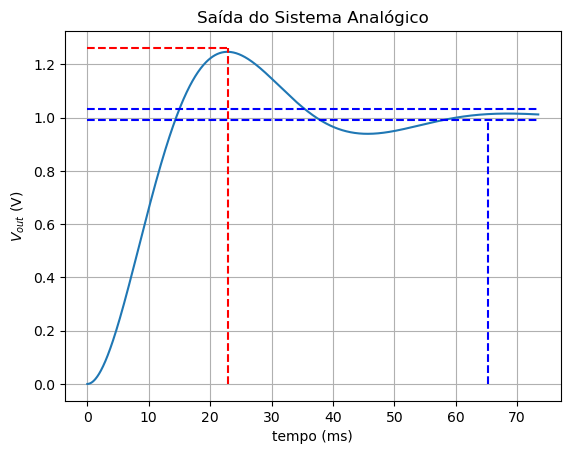

In [4]:
import matplotlib.pyplot as plt
import control as ct

s = ct.tf('s')
t = np.linspace(0, (Ts+τ/2), 1000)  # t = tempo de acomodação 2% + meia constante de tempo
G = w2/(s**2 + s*2*z*w + w2)
t, y = ct.step_response(G, T=t)
tms  = 1e3*t
plt.plot(tms, y)
plt.xlabel("tempo (ms)")
plt.ylabel("$V_{out}$ (V)")
plt.title("Saída do Sistema Analógico")
## Plotando tempo de pico, tempo do acomodamento e sobressinal ##
plt.plot(tms[t<=tp], y[-1]*(1+Mp)*np.ones(len(tms[t<=tp])), 'r--')
plt.plot([tp*1e3, tp*1e3], [0, y[-1]*(1+Mp)], 'r--')

ys  = y[np.abs(y - y[-1]*(1-2e-2)) <= 1e-5]
plt.plot([Ts*1e3, Ts*1e3], [0, ys[0]], 'b--')
plt.plot(tms, np.ones(len(y))*y[-1]*(1-2e-2), 'b--')    # Limite inferior para 2%
plt.plot(tms, np.ones(len(y))*y[-1]*(1+2e-2), 'b--')    # Limite superior para 2%

plt.grid(True, 'both')
plt.savefig("Analogico.svg", format="svg")

In [5]:
# Comparando valores do gráfico com os calculados
Tp_ms = tms[y == np.max(y)]
Mp_es = 100*(np.max(y) - 1)

print("Tp_ms: ", round(Tp_ms[0], 3), "ms")
print("Mp_es: ", round(Mp_es, 3), "%")

Tp_ms:  22.863 ms
Mp_es:  24.69 %


Podemos ver que os valores calculados, estimados e simulados concordam um com o outro, faltando apenas a comparação em bancada para determinar a validade dos cálculos

In [6]:
from PyLTSpice import RawRead

LTR = RawRead("Input Files/Analogico.raw")

print(LTR.get_trace_names())
print(LTR.get_raw_property())

['time', 'V(vin)', 'V(n001)', 'V(n002)', 'V(vout)', 'I(C2)', 'I(C1)', 'I(R2)', 'I(R1)', 'I(V1)', 'Ix(u1:3)']
OrderedDict([('Filename', WindowsPath('Input Files/Analogico.raw')), ('Title', '* C:\\Users\\emanuel\\Documents\\Uni\\Controle_2\\Analogico\\Analogico.asc'), ('Date', 'Sun Oct 13 15:46:11 2024'), ('Plotname', 'Transient Analysis'), ('Flags', 'real forward'), ('No. Variables', 11), ('No. Points', 59), ('Offset', '0.0000000000000000e+000'), ('Command', 'Linear Technology Corporation LTspice XVII -- Alternate Solver'), ('Backannotation', 'u1 1 2 3'), ('Variables', ['time', 'V(vin)', 'V(n001)', 'V(n002)', 'V(vout)', 'I(C2)', 'I(C1)', 'I(R2)', 'I(R1)', 'I(V1)', 'Ix(u1:3)'])])


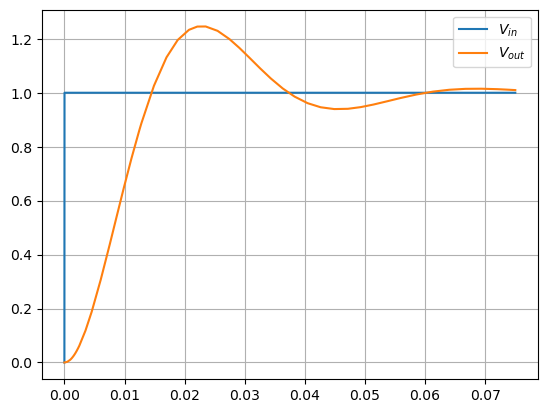

In [7]:
Vout  = LTR.get_trace("V(vout)")
Vin   = LTR.get_trace("V(vin)")
####
time  = LTR.get_trace("time")
steps = LTR.get_steps()
for step in range(len(steps)):
    # print(steps[step])
    plt.plot(time.get_wave(step), Vin.get_wave(step), label=steps[step])
    plt.plot(time.get_wave(step), Vout.get_wave(step), label=steps[step])

plt.legend(["$V_{in}$", "$V_{out}$"])
plt.grid()
plt.show()

In [8]:
Mp_sim = (np.max(Vout)-1)
Tp_sim = time[Vout == np.max(Vout)][0]

print("Mp simulado: ", round(100*Mp_sim, 3), "%")
print("Tp simulado: ", round(1e3*Tp_sim, 3), "s")

Mp simulado:  24.568 %
Tp simulado:  23.501 s


In [9]:
diff_Mp = 100*(Mp-Mp_sim)/Mp
diff_Tp = 100*(tp-Tp_sim)/tp

print("diferença entre Mp calculado e simulado: ", round(diff_Mp, 3), "%")
print("diferença entre Tp calculado e simulado: ", round(diff_Tp, 3), "%")

diff_Tp2 = 100*(Tp_ms[0]-1e3*Tp_sim)/Tp_ms[0] # Tempo de pico simulado por G(s)
print("diferença entre Tp simulado por G(s) e pelo LTSpice: ", round(diff_Tp2, 3), "%")

diferença entre Mp calculado e simulado:  0.497 %
diferença entre Tp calculado e simulado:  -2.949 %
diferença entre Tp simulado por G(s) e pelo LTSpice:  -2.791 %


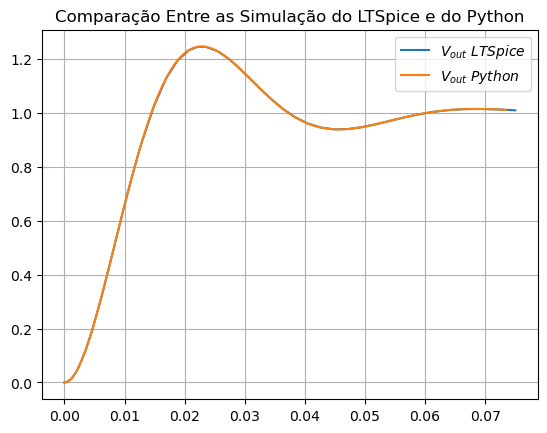

In [10]:
k=0
Vout_array = np.zeros(len(Vout))
for step in range(len(steps)):
    Vout_array[k*len(steps):] = Vout.get_wave(step)
    plt.plot(time.get_wave(step), Vout.get_wave(step), label=steps[step])
    k = k +1

plt.plot(t, y)
plt.legend(["$V_{out} \ LTSpice$", "$V_{out} \ Python$"])
plt.title("Comparação Entre as Simulação do LTSpice e do Python")
plt.grid(True, 'both')

plt.savefig("Comparacao_LT_Gs.svg", format="svg")

Podemos ver que o resultado calculado a partir de G(s) e o valor simulado pelo LTSpice são quase idênticos

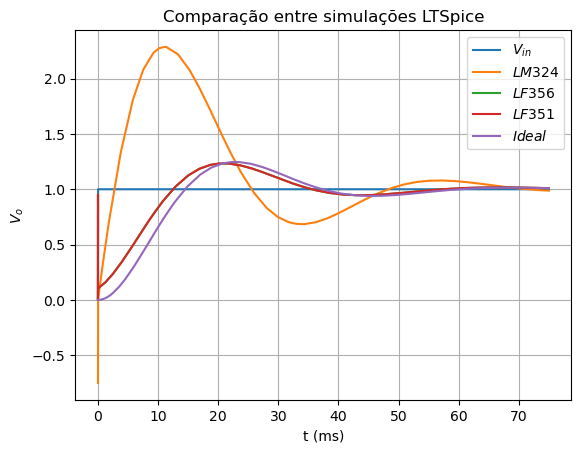

In [11]:
# Comparando Simulção Ideal e com Componentes "Reais"
LTR_LF356 = RawRead("Input Files/Analogico_LF356.raw")
LTR_LF351 = RawRead("Input Files/Analogico_LF356.raw")
LTR_LM324 = RawRead("Input Files/Analogico_LM324.raw")

Vout_LM324  = LTR_LM324.get_trace("V(vout)")
Vin_LM324   = LTR_LM324.get_trace("V(vin)")

Vout_LF356  = LTR_LF356.get_trace("V(vout)")
Vin_LF356   = LTR_LF356.get_trace("V(vin)")

Vout_LF351  = LTR_LF351.get_trace("V(vout)")
Vin_LF351   = LTR_LF351.get_trace("V(vin)")
####
time_LM324  = LTR_LM324.get_trace("time")
steps_LM324 = LTR_LM324.get_steps()

time_LF356  = LTR_LF356.get_trace("time")
steps_LF356 = LTR_LF356.get_steps()

time_LF351  = LTR_LF351.get_trace("time")
steps_LF351 = LTR_LF351.get_steps()

for step in range(len(steps_LM324)):
    plt.plot(1e3*time_LM324.get_wave(step), Vin_LM324.get_wave(step), label=steps[step])
    plt.plot(1e3*time_LM324.get_wave(step), Vout_LM324.get_wave(step), label=steps[step])

for step in range(len(steps_LF356)):
    plt.plot(1e3*time_LF356.get_wave(step), Vout_LF356.get_wave(step), label=steps[step])

for step in range(len(steps_LF351)):
    plt.plot(1e3*time_LF351.get_wave(step), Vout_LF351.get_wave(step), label=steps[step])

for step in range(len(steps)):
    # print(steps[step])
    plt.plot(1e3*time.get_wave(step), Vout.get_wave(step), label=steps[step])

plt.legend(["$V_{in}$", "$LM324$", "$LF356$", "$LF351$", "$Ideal$"])
plt.title("Comparação entre simulações LTSpice")
plt.grid(True)

plt.xlabel("t (ms)")
plt.ylabel("$V_o$")

plt.show()

Analisando os gráficos das simulações, vê-se necessário o uso do ampop LMF336 ou LMF335 de acordo com disponibilidade.

## Transformada z da Planta

0 states have been removed from the model

   0.349 z + 0.2653
----------------------
z^2 - 0.835 z + 0.4493

dt = 0.006527999999999997



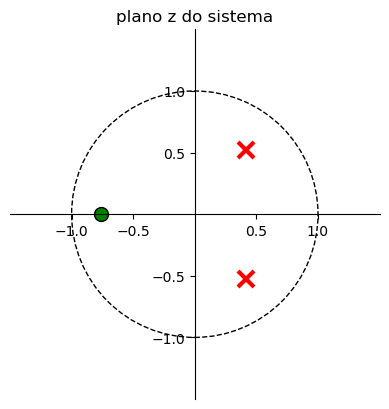

In [12]:
from matplotlib import rcParams
from matplotlib.figure import Figure
from matplotlib import patches

Ta = Ts/10
Gz = ct.minreal(ct.c2d(G, Ta))
print(Gz)
ctl.zplane(Gz)
plt.show()

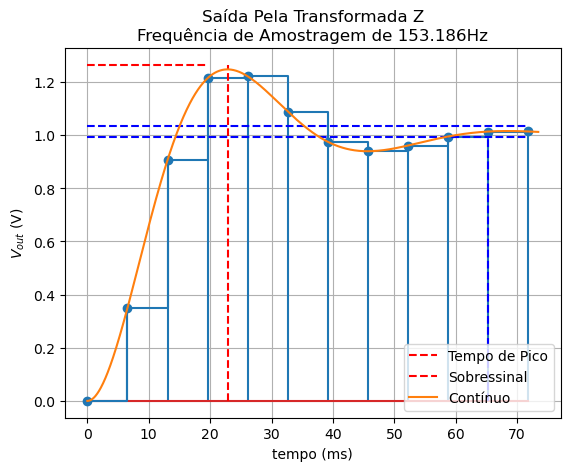

In [13]:
tz = np.arange(0, (Ts+τ/2), Ta)
ax, tz, yz = ctl.plot_step(Gz, tz, xl="tempo (ms)", yl="$V_{out}$ (V)",
                   title="Saída Pela Transformada Z\nFrequência de Amostragem de " + str((round(1/Ta,3))) + "Hz")
###
# Sobressinal
ax.plot([Tp_ms, Tp_ms], [0, yz[-1]*(1+Mp)], "r--", label="Tempo de Pico")
ax.plot(1e3*tz[tz<=tp], yz[-1]*(1+Mp)*np.ones(len(tz[tz<=tp])), "r--", label="Sobressinal")
# Tempo de Acomodação (2%)
ax.plot([Ts*1e3, Ts*1e3], [0, ys[0]], 'b--')
# Valor de Acomodação (2%)
ax.plot(1e3*tz, np.ones(len(yz))*yz[-1]*(1-2e-2), 'b--')
ax.plot(1e3*tz, np.ones(len(yz))*yz[-1]*(1+2e-2), 'b--')
# Valor Contínuo Simulado por G
ax.plot(tms, y, label="Contínuo")
plt.legend(loc = "lower right")
plt.show()

## Equação Recursiva da Planta

b = [0.34899172 0.26529613]
a = [ 1.         -0.83504112  0.44932896]


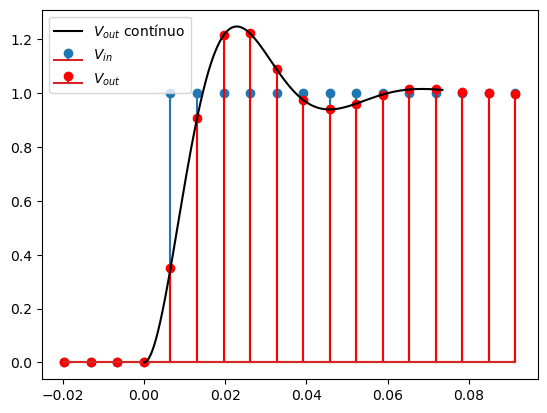

In [15]:
import scipy.signal as sp

b = Gz.num[0][0]
a = Gz.den[0][0]

print("b =", b)
print("a =", a)
# Verificando Coeficientes
tz = np.arange(-len(a)*Ta, (Ts+2*τ), Ta)
u  = np.heaviside(tz, 0) # degrau (saída do microcontrolador)
ua = 0 # Acumula b[0]*u[k] + ... + b[n]*u[k-n]
ya = 0 # Acumula a[1]*y[k-1] + ... + a[n]*y[k-n]
yf = np.zeros(len(tz))
n0 = len(a)
for n in range(n0, len(tz)): # i = n-max(len(a), len(b))
    j = 0
    ua=0
    ya=0
    for bn in b:
        ua = ua + bn*u[n-j]
        j  = j+1
    j = 1
    for an in a[1:]:
        ya = ya + an*yf[n-j]
        j = j+1
    yf[n] = (ua-ya)/a[0]
    n = n+1

plt.stem(tz, u, label="$V_{in}$")
plt.stem(tz, yf, "r", label="$V_{out}$")
plt.plot(t, y, "k", label="$V_{out}$ contínuo")
plt.legend()
plt.show()

## Ajustando C(z) por Root Locus

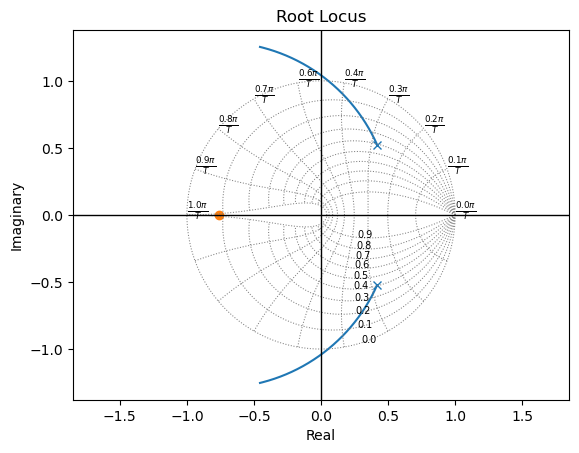

In [ ]:
z = ct.tf('z')
k = np.linspace(0, 5, 1000)
root_locus = ct.root_locus(Gz, kvect=k)
plt.show()